In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# examine the data, see a sample row
first_row_station = session.query(station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25eec1e4898>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [10]:
# create inspector object and find the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Print column names and types for the measurement table
meas_columns = inspector.get_columns('measurement')
for column in meas_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


## Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set, convert string format to date.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date = (dt.datetime.strptime(most_recent_date, '%Y-%m-%d')).date()
most_recent_date

datetime.date(2017, 8, 23)

In [13]:
# Calculate the date one year prior to the most recent date in dataset
analysis_start_date = most_recent_date - dt.timedelta(days=365)
analysis_start_date

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(measurement.date, measurement.prcp).\
    filter((measurement.date <= most_recent_date) & (measurement.date >= analysis_start_date)).all()
print(prcp_data[0])
print(prcp_data[0].date)
print(prcp_data[0].prcp)


('2016-08-23', 0.0)
2016-08-23
0.0


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
meas_df = pd.DataFrame(prcp_data)
meas_df = meas_df.set_index('date')
meas_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [16]:
# Sort the DataFram by date and drop rows containing NaN values
meas_df = meas_df.sort_index()
meas_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [17]:
# Rename column for cleaner DataFrame and for plot legend
meas_df = meas_df.rename(columns = {'prcp': 'Precipitation'})
meas_df.head()

,Precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


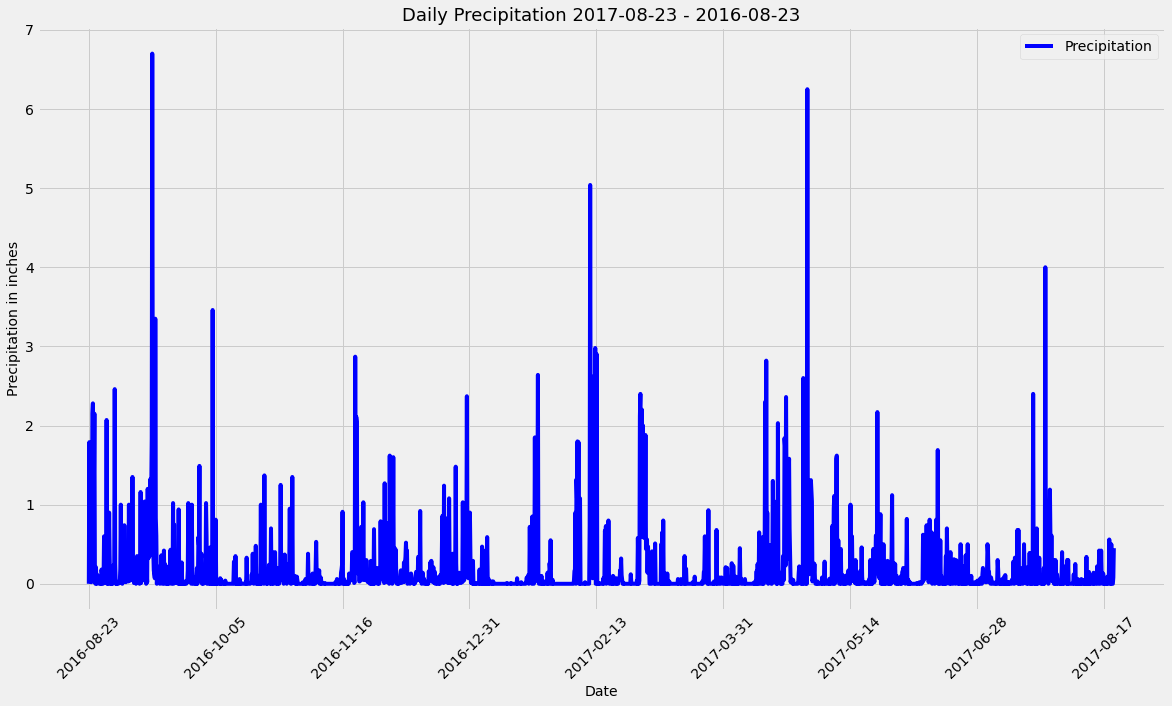

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
panda_plot = meas_df.plot(figsize = (18,10), color="blue", alpha=1, legend=True, rot=45)

panda_plot.set_title(f'Daily Precipitation {most_recent_date} - {analysis_start_date}', fontsize=18)
panda_plot.set_xlabel('Date', fontsize=14)
panda_plot.set_ylabel('Precipitation in inches', fontsize=14)

# Save plot to image file
plt.savefig('Images/Daily_Precipitation_panda_plot.jpg')

# Display plot
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
meas_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Exploratory Station Analysis

In [20]:
# Print column names and types for the station table
sta_columns = inspector.get_columns('station')
for column in sta_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [21]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station).count()

print(f'The total number of stations is: {total_stations}')

The total number of stations is: 9


In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
most_active = session.query(measurement.station, func.count(measurement.station), station.name, station.id).\
    order_by(func.count(measurement.station).desc()).\
    group_by(measurement.station).all()

# List the stations and the counts in descending order.
most_active

[('USC00519281', 24948, 'WAIKIKI 717.2, HI US', 1),
 ('USC00519397', 24516, 'WAIKIKI 717.2, HI US', 1),
 ('USC00513117', 24381, 'WAIKIKI 717.2, HI US', 1),
 ('USC00519523', 24021, 'WAIKIKI 717.2, HI US', 1),
 ('USC00516128', 23508, 'WAIKIKI 717.2, HI US', 1),
 ('USC00514830', 19818, 'WAIKIKI 717.2, HI US', 1),
 ('USC00511918', 17811, 'WAIKIKI 717.2, HI US', 1),
 ('USC00517948', 12348, 'WAIKIKI 717.2, HI US', 1),
 ('USC00518838', 4599, 'WAIKIKI 717.2, HI US', 1)]

In [23]:
# Declare variables to store extracted tuples from list
most_active_station = most_active[0]
activest_station = most_active_station[0]
activest_station_id = most_active_station[3]
activest_station_meas_count = most_active_station[1]

print(f'The most active station is {activest_station} with a measurement count of {activest_station_meas_count}')

The most active station is USC00519281 with a measurement count of 24948


In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Lowest temperature for most active station 
low_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == activest_station)[0][0]
                         
print(f'At the most active station {activest_station} ({activest_station_id}) the lowest temp recorded was {low_temp}°F.')

At the most active station USC00519281 (1) the lowest temp recorded was 54.0°F.


In [36]:
# Highest temperature for most active station 
high_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == activest_station)[0][0]
    
print(f'At the most active station {activest_station} ({activest_station_id}) the highest temp recorded was {high_temp}°F.')

At the most active station USC00519281 (1) the highest temp recorded was 85.0°F.


In [38]:
# Average temperature from most active station 
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == activest_station)[0][0]

print(f"At the most active station, the average temp recorded was {avg_temp:.2f}°F.")

At the most active station, the average temp recorded was 71.66°F.


In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(measurement.tobs).\
        filter((measurement.station == activest_station) \
        & (measurement.date <= most_recent_date) \
        & (measurement.date >= analysis_start_date)).all()
#tobs_data

In [28]:
# Save query results as Pandas DataFrame
most_active_tobs_df = pd.DataFrame(tobs_data)
most_active_tobs_df = most_active_tobs_df.rename(columns={'tobs': 'Temperature Observation'})

most_active_tobs_df

,Temperature Observation
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


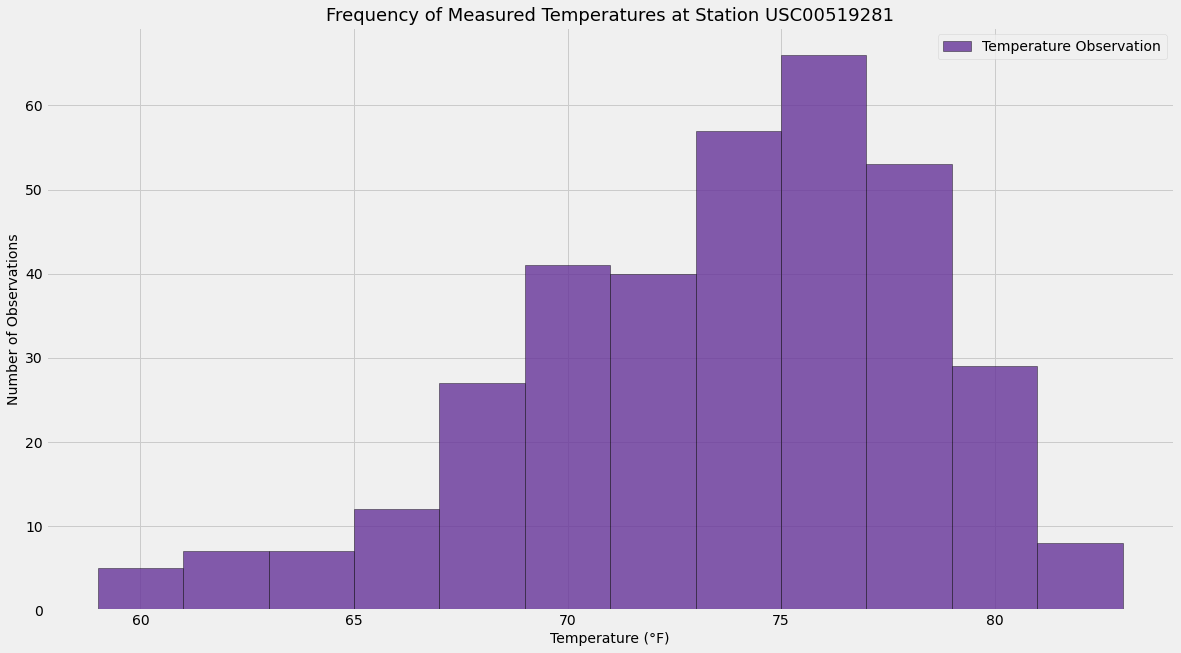

In [41]:
# Plot the results as a histogram with bins=12
most_active_tobs_df.plot.hist(color="rebeccapurple", ec="k", alpha=0.8, figsize=(18, 10), bins=12)

plt.title(f'Frequency of Measured Temperatures at Station {activest_station}', fontsize=18)
plt.xlabel('Temperature (°F)', fontsize=14)
plt.ylabel('Number of Observations', fontsize=14)

# Print histogram plot to image file
plt.savefig('Images/Temperatures_Histogram.jpg')

plt.show()

### Close session

In [30]:
# Close Session
session.close()